In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats
from statsmodels.stats import diagnostic
import scipy as sp


In [166]:
df = pd.read_csv("opp-stops_state.csv")
counties =  pd.read_csv('2016_US_County_Level_Presidential_Results.csv')

In [167]:
# drop all NaN values
df.drop(columns = ['city', 'geography'], inplace = True)
df.dropna(inplace = True)
counties = counties.dropna()
# add number of searches column
df['nb_search'] = df.search_rate * df.stops_per_year


In [168]:
#Définir array des états bleus et rouges
red_states = ['SC', 'TX']
blue_states  = ['IL', 'CT', 'RI']

#Fonction pour trier les états en blue et red: 
def what_party (name): #retourne toujours none !
    if any(s == name for s in blue_states):
        return 'blue'
    elif any(s == name for s in red_states):
        return 'red'
    else:
        return 'none'
    
def sort_array_of_state(dataframe):
    partys = []
    for state in dataframe['state']:
        partys.append(what_party(state))
    return partys
    
#Trier les états de notre dataframe:
df['party'] = sort_array_of_state(df)


In [169]:
blue = df[df['party'].str.contains('blue')].reset_index(drop = True)
red = df[df['party'].str.contains('red')].reset_index(drop = True)
full = pd.concat([blue,red]).reset_index(drop = True)
full_pivot = full.pivot(index = ['party', 'state', 'subgeography'] , columns = 'subject_race')
full_pivot.head()

search_rate                     stop_rate  \
subject_race                        black  hispanic     white     black   
party state subgeography                                                  
blue  CT    Fairfield County     0.029384  0.020520  0.013487  0.073116   
            Hartford County      0.036567  0.036986  0.012005  0.073116   
            Litchfield County    0.034749  0.038982  0.016265  0.073116   
            New Haven County     0.028742  0.030105  0.011492  0.073116   
            New London County    0.031647  0.029246  0.014475  0.073116   

                                                   hit_rate            \
subject_race                   hispanic     white     black  hispanic   
party state subgeography                                                
blue  CT    Fairfield County   0.039236  0.065458  0.315113  0.257426   
            Hartford County    0.039236  0.065458  0.303398  0.294776   
            Litchfield County  0.039236  0.065458  0.301587  0.438776   
            New Haven County   0.039236  0.065458  0.247191  0.302548   
            New London County  0.039236  0.065458  0.331683  0.325926   

                                        inferred_threshold  ...            \
subject_race                      white              black  ...     white   
party state subgeography                                    ...             
blue  CT    Fairfield County   0.356108           0.171864  ...  0.223550   
            Hartford County    0.319820           0.155822  ...  0.238114   
            Litchfield County  0.413978           0.184323  ...  0.262494   
            New Haven County   0.357401           0.166497  ...  0.233488   
            New London County  0.335580           0.172387  ...  0.225318   

                              stops_per_year                    stop_rate_n  \
subject_race                           black hispanic     white       black   
party state subgeography                                                      
blue  CT    Fairfield County         5080.32  4725.12  17189.76    25650.72   
            Hartford County          5408.16  3623.00  17752.80    25650.72   
            Litchfield County         906.50  1257.00  16466.88    25650.72   
            New Haven County         5945.28  5006.40  23139.36    25650.72   
            New London County        3063.84  2215.68  24605.76    25650.72   

                                                   nb_search                   
subject_race                   hispanic      white     black hispanic   white  
party state subgeography                                                       
blue  CT    Fairfield County   21654.72  160113.12    149.28    96.96  231.84  
            Hartford County    21654.72  160113.12    197.76   134.00  213.12  
            Litchfield County  21654.72  160113.12     31.50    49.00  267.84  
            New Haven County   21654.72  160113.12    170.88   150.72  265.92  
            New London County  21654.72  160113.12     96.96    64.80  356.16  

[5 rows x 21 columns]

We will be examining hit rates and threshold, they are computed individually for each subject race and each county.

These variables are ....

They depend on the number of searches:

(118.81183750799273, 70.39172426420102)

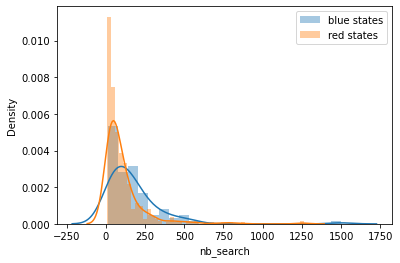

In [170]:
g = sns.distplot(blue.nb_search, label = 'blue states')
sns.distplot(red.nb_search, label = 'red states', ax = g)
plt.legend()
full.nb_search.mean(), full.nb_search.median()

As we can see the number of searches per county and per subject race follows a power law distribution. This is indeed due to the fact that, like city sizes, county sizes follow a power law distribution since there is a majority of small, low population counties with a heavy tail of large counties with high population.

(0.3033774690616758, 0.3561253711992615)

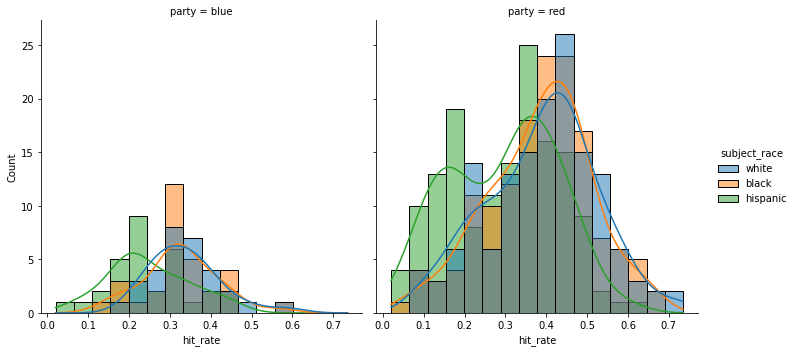

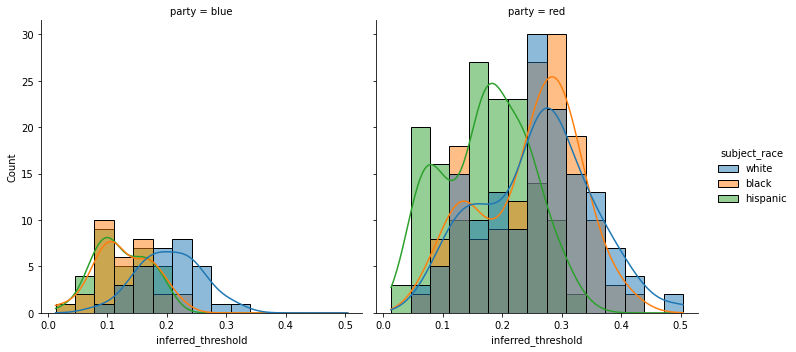

In [171]:
#we can add distribution of hit rate and threshold but boxplots look fine to me.
sns.displot(data=full, x="hit_rate", hue="subject_race", col="party", kde = True)
# fig, axes = plt.subplots(2,2,figsize = (8,8))
# parties = [blue,red]
# value = ['hit_rate', 'inferred_threshold']
# for i in range(4):
#     print(i%2)
#     sns.kdeplot(data=parties[i%2], x=value[i%2], hue="subject_race", ax = axes[i%2,i%2])

# fig,ax=plt.subplots()

sns.displot(data=full, x="inferred_threshold", hue="subject_race", col="party", kde=True)
# we can plot the non weighted vs weighted means for blue and red states to compare with the distribution
blue.hit_rate.mean(), red.hit_rate.mean()

These distributions hint that there may be an underlying subdistribution in the red states. This is probably due to only having two red states which may have rather different policing trends. We can also note that the values are quite far from being normally distributed.

In [172]:
# Here we do some diagnostics. 
# We want to know if the county specific, race specific hit rates and thresholds have normal distribution
# We can do this either over the full dataframe or over the blue and red dataframes separately
print(diagnostic.kstest_normal(blue.hit_rate, dist = 'norm'))
print(diagnostic.kstest_normal(red.hit_rate, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['blue'].hit_rate.white, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['blue'].inferred_threshold.hispanic, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['red'].hit_rate.white, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['red'].inferred_threshold.hispanic, dist = 'norm'))

(0.06327091097213672, 0.5048916402425464)
(0.06421953443341571, 0.0009999999999998899)
(0.1007900857526729, 0.5778193798896908)
(0.13244668732730136, 0.1885279279732509)
(0.065747278715727, 0.17403441585970786)
(0.07866208425108001, 0.0414062467744477)


<AxesSubplot:xlabel='subject_race', ylabel='inferred_threshold'>

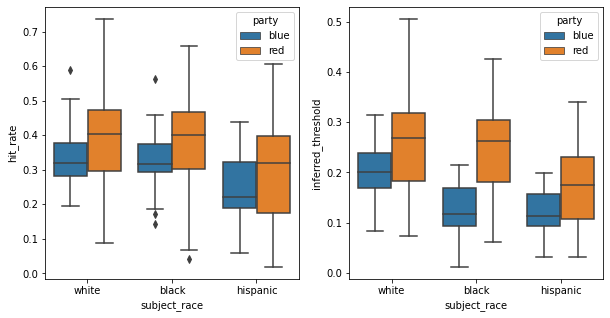

In [173]:
# boxplots also give a good representation of distribution and shit
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data=full, y="hit_rate", x="subject_race", hue = 'party', ax = ax[0])
sns.boxplot(data=full, y="inferred_threshold", x="subject_race", hue = 'party', ax = ax[1])

We describe here our two variables of interest over our whole working dataset (blue and red states).
Values look overall pretty close, hispanic rates being lower.

Now its time to test our data, but for this we need to know what test to use and to know what test to use we need to know what kind of distribution the data has. Therefore we use statistical tests.

In [174]:
# both these tests allow us to examine correlation between two variables
# we can for example look at the correlation between a dependent variable and the hit rate or threshold as these are the independent
# variables we would like to assess
# spearman does not take the assumption that data is normally distributed
print(stats.spearmanr(full['inferred_threshold'],full['hit_rate']))
print(stats.spearmanr(full['nb_search'],full['hit_rate']))
print(stats.spearmanr(full['nb_search'],full['inferred_threshold']))

SpearmanrResult(correlation=0.8585609764310043, pvalue=2.4298148536076406e-157)
SpearmanrResult(correlation=-0.13885515863802225, pvalue=0.0012559093273109832)
SpearmanrResult(correlation=-0.23679512999655253, pvalue=2.796766404058407e-08)


We can see for example that hit rate and threshold are quite well correlated whereas number of searches and hit_rate are actually negatively correlated! This shows that increasing the number of searches may not actually increase the chances of finding contraband. Rather the more you search the more likely you are to find nothing. 

In [175]:
print(stats.spearmanr(full_pivot.loc['red']['nb_search','hispanic'],full_pivot.loc['red']['hit_rate','hispanic']))
print(stats.spearmanr(full_pivot['nb_search','black'], full_pivot['hit_rate','black']))
print(stats.spearmanr(full_pivot['nb_search','hispanic'], full_pivot['hit_rate','hispanic']))

SpearmanrResult(correlation=0.148823185358741, pvalue=0.0710390610171311)
SpearmanrResult(correlation=-0.42128284611037853, pvalue=4.292020147034426e-09)
SpearmanrResult(correlation=0.12712871577165907, pvalue=0.08991654432313753)


We can see above how we might use correlation to explore some causalities, however this is quite naive and superficial analysis.

Our objective is to compare our independent variables (hit rate and inferred threshold) between blue and red states. Nevertheless, the visualizations are not enough to see a difference. Therefore, we will carry out tests on these variables to determine if significant differences exist between blue and red states. 

First we will calculate the mean race specific hit rates and thresholds for blue states and red states. This can be done by giving each county an equal weight (unweighted mean) or giving each county a weight proportional to the race specific number of searches (weighted mean).
Then we choose a statistical test and carry it out to compare race specific, party specific mean hit rates and thresholds.

In [176]:
print("unweighted means:", blue.hit_rate.mean(), red.hit_rate.mean(), blue.inferred_threshold.mean(), red.inferred_threshold.mean())

unweighted means: 0.3033774690616758 0.3561253711992615 0.15203333226969742 0.2245221985323473


In [177]:
full.head()
full.groupby(['party','subject_race']).mean().loc[:,'hit_rate':'inferred_threshold']

hit_rate  inferred_threshold
party subject_race                              
blue  black         0.325693            0.127468
      hispanic      0.248095            0.124068
      white         0.336344            0.204564
red   black         0.384179            0.245381
      hispanic      0.294927            0.171971
      white         0.389270            0.256215

Now we calculate the weighted means by giving each county a race specific weight. 

Each row will hence get a weight: 
w(i) = nb_search(i)/sum(nb_search of corresponding race in dataframe)

This will be done for blue and red dataframe so as to give higher weight to counties with a lot of searches and less to counties with few.

In [178]:
def get_weight(nb_search):
    return nb_search/nb_search.sum()
def get_normalize(values):
    return values/values.white
# def weighted_mean()

In [179]:
import warnings
warnings.filterwarnings('ignore')

weights = full_pivot.loc['blue'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
blue = blue.merge(weights, on = ['subgeography','state', 'subject_race'])

weights = full_pivot.loc['red'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
red = red.merge(weights, on = ['subgeography','state', 'subject_race'])


#create dataframes with normalized values, using the pivoted dataframe so we can apply get normalize to each row containing race specific
hit_rate_normalized = full_pivot.hit_rate.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'hit_rate_normalized'})
threshold_normalized = full_pivot.inferred_threshold.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'threshold_normalized'})

blue = blue.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])
red = red.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])


blue['hit_rate_weighted'] = blue.hit_rate*blue.weight
blue['threshold_weighted'] = blue.inferred_threshold*blue.weight
red['hit_rate_weighted'] = red.hit_rate*red.weight
red['threshold_weighted'] = red.inferred_threshold*red.weight
blue['hit_rate_weighted_normalized'] = blue.hit_rate_normalized*blue.weight
blue['threshold_weighted_normalized'] = blue.threshold_normalized*blue.weight
red['hit_rate_weighted_normalized'] = red.hit_rate_normalized*red.weight
red['threshold_weighted_normalized'] = red.threshold_normalized*red.weight

In [180]:
blue
red.groupby('subject_race').mean()

,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_search,weight,hit_rate_normalized,threshold_normalized,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
subject_race,,,,,,,,,,,,,,
black,0.034480,0.098364,0.384179,0.245381,2878.668220,226350.906342,91.270352,0.006757,1.011336,0.968235,0.002199,0.001264,0.007221,0.006260
hispanic,0.038760,0.080105,0.294927,0.171971,3055.606840,575489.089351,78.950636,0.006757,0.742274,0.659872,0.001959,0.001122,0.005222,0.004697
white,0.017934,0.105538,0.389270,0.256215,8288.457356,929772.681121,153.823901,0.006757,1.000000,1.000000,0.002238,0.001425,0.006757,0.006757


In [181]:
results_blue = pd.concat([blue.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          blue.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T

In [182]:
results_red = pd.concat([red.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          red.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T

In [183]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(results_blue,results_red)

subject_race,black,hispanic,white
hit_rate,0.325693,0.248095,0.336344
inferred_threshold,0.127468,0.124068,0.204564
hit_rate_normalized,0.979727,0.728333,1.000000
threshold_normalized,0.608307,0.595508,1.000000
hit_rate_weighted,0.269347,0.221746,0.332913
threshold_weighted,0.090865,0.105771,0.200126
hit_rate_weighted_normalized,0.904966,0.685482,1.000000
threshold_weighted_normalized,0.492870,0.565019,1.000000
subject_race,black,hispanic,white
hit_rate,0.384179,0.294927,0.389270


Here we have two tables (blue on the left red on the right), they contain party average race specific hit rates and inferred thresholds given no change, normalization with respect to white values, weighted average calculation and weighted average of normalized data.

Comparing red results vs blue results shows that normalized means are lower in blue states than in red states. Also, while weighted means

In [184]:
# compare normalized hit rate and threshold between red and blue
# We use mannwhitney test because we ar comparing two samples but our values distribution are not normal
print(stats.mannwhitneyu(blue.hit_rate, red.hit_rate, alternative='two-sided'))
print(stats.mannwhitneyu(blue.hit_rate_normalized, red.hit_rate_normalized, alternative='two-sided'))


MannwhitneyuResult(statistic=15116.0, pvalue=4.8241199695765465e-05)
MannwhitneyuResult(statistic=19562.5, pvalue=0.4171405489457858)


We can see that normalizing is important as it does not give the same results at all. Without normalization the means are clearly not the same. However since the p value is not less than 0.05 we cannot reject the null hypothesis that mean hit rates are the same.

Lets check out some more tests: (we only consider normalized values as only they can be compared)

In [185]:
print("mean threshold pvalue:", stats.mannwhitneyu(blue.threshold_normalized, red.threshold_normalized, alternative='two-sided')[1])
print("mean black threshold pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'black'].threshold_normalized, 
                         red[red.subject_race == 'black'].threshold_normalized, alternative='two-sided')[1])
print("mean hispanic threshold pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].threshold_normalized, 
                         red[red.subject_race == 'hispanic'].threshold_normalized, alternative='two-sided')[1])
print("mean hit rate pvalue:", stats.mannwhitneyu(blue.hit_rate_normalized, red.hit_rate_normalized, alternative='two-sided')[1])
print("mean black hit rate pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'black'].hit_rate_normalized, 
                         red[red.subject_race == 'black'].hit_rate_normalized, alternative='two-sided')[1])
print("mean hispanic hit rate pvalue:",stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].hit_rate_normalized, 
                         red[red.subject_race == 'hispanic'].hit_rate_normalized, alternative='two-sided')[1])

mean threshold pvalue: 1.4028945443066947e-08
mean black threshold pvalue: 1.0373127111540843e-16
mean hispanic threshold pvalue: 0.0028206933708296938
mean hit rate pvalue: 0.4171405489457858
mean black hit rate pvalue: 0.5457188088401649
mean hispanic hit rate pvalue: 0.7016478592647909


Given these pvalues we can only reject the null hypothesis that the threshold means are the same and not the hit rate means. Again these are for normalized values. 
This would suggest that thresholds in blue states are significantly lower for minorities.


In [186]:
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate_normalized, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate_normalized, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided'))

MannwhitneyuResult(statistic=25608488.0, pvalue=8.197822136371379e-306)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)


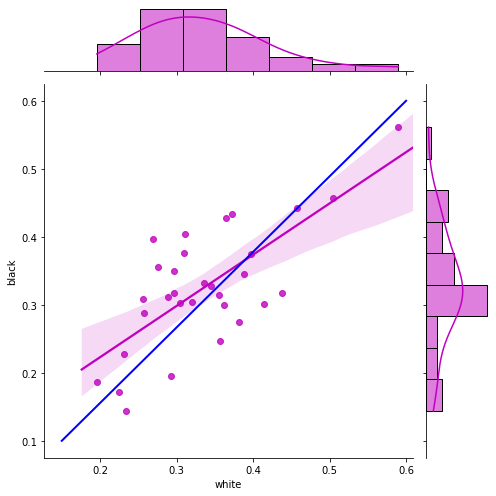

In [187]:
# fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,10))
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).black.hit_rate, label = 'black', ax = ax1)
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).white.hit_rate, label = 'white', ax=ax1 )
# ax1.legend()
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).hispanic.hit_rate, label = 'blue', ax = ax2)
# sns.distplot(df_red_pivot.swaplevel(1,0, axis = 1).hispanic.hit_rate, label = 'red', ax=ax2)
plot = sns.jointplot(x=full_pivot.loc['blue'].hit_rate.white, y=full_pivot.loc['blue'].hit_rate.black, data=blue,
                  kind="reg", truncate=False,
                  color="m", height=7)

plot.ax_joint.plot([0.15,0.6], [0.1,0.6], 'b-', linewidth = 2)

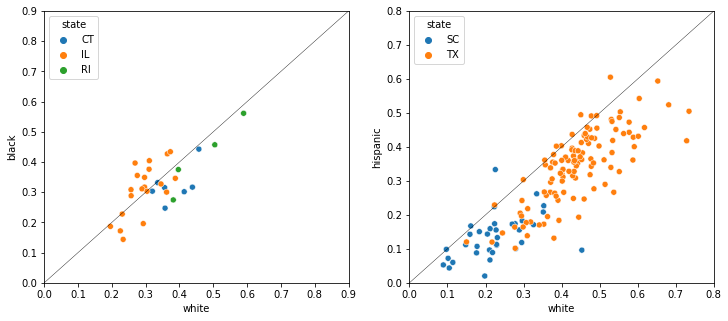

In [188]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(range(10),range(10), color = 'black', lw = 0.4)
ax1.set_xlim([0,0.9])  
ax1.set_ylim([0,0.9]) 
g = sns.scatterplot(data = full_pivot.loc['blue'], x = full_pivot.loc['blue'].hit_rate.white, y = full_pivot.loc['blue'].hit_rate.black, hue = 'state', ax =ax1)
# h,l = g.get_legend_handles_labels()
# ax1.legend(h[0:5],l[0:5])

ax2.plot(range(10),range(10), color = 'black', lw = 0.4)
ax2.set_xlim([0,0.8]) 
ax2.set_ylim([0,0.8]) 
sns.scatterplot(data = full_pivot.loc['red'], x = full_pivot.loc['red'].hit_rate.white, y = full_pivot.loc['red'].hit_rate.hispanic, hue = 'state', ax =ax2)
plt.show(g)

In [189]:
df_pivot = pd.concat([df_blue_pivot,df_red_pivot])
df_pivot.head()

NameError: name 'df_blue_pivot' is not defined

In [190]:
def get_weights(df, states, races):
    df['weights'] = np.zeros(df.shape[0])
    for state in states:
        for race in races:
            df.loc[state,race].weights = df.loc[state,race].nb_search/df.loc[state,race].nb_search.sum()
    return df

In [191]:
def add_normalized_rates(df):
    df_white = df[df.subject_race == 'white'].reset_index(drop = True)
    df_black = df[df.subject_race == 'black'].reset_index(drop = True)
    df_hispanic = df[df.subject_race == 'hispanic'].reset_index(drop = True)
    df_black['hit_rate_normalized'] = (df_black.hit_rate / df_white.hit_rate) #*df_black.weights
    df_hispanic['hit_rate_normalized'] = (df_hispanic.hit_rate / df_white.hit_rate)#*df_hispanic.weights
    df_black['threshold_normalized'] = (df_black.inferred_threshold / df_white.inferred_threshold)#*df_black.weights
    df_hispanic['threshold_normalized'] = (df_hispanic.inferred_threshold / df_white.inferred_threshold)#*df_hispanic.weights
    return pd.concat([df_hispanic,df_black])


In [192]:
def weighted_mean(x):
#     print(x)
    return np.mean(x)

In [193]:
# plot bar graphs by political orientation (blue/red) and by method (hit rate/threshold)
def plot_bar(method, data, params):
    ylim, ax = params
    sns.barplot(x = "state", y = method, hue = "subject_race", data = data, estimator = np.mean, ax = ax)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.5,4.5])
    ax.axhline(y=1, ls = (1, (10,5)), color = 'black', lw = 0.7)
    x = np.arange(-0.5, 2.5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#5DADE2", alpha =0.5)    
    x = np.arange(2.5, 5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#E74C3C", alpha =0.5)
#     ax.set_xlim(lim)
#     ax.set_ylim(lim)

ValueError: Could not interpret input 'hit_rate_weighted_normalized'

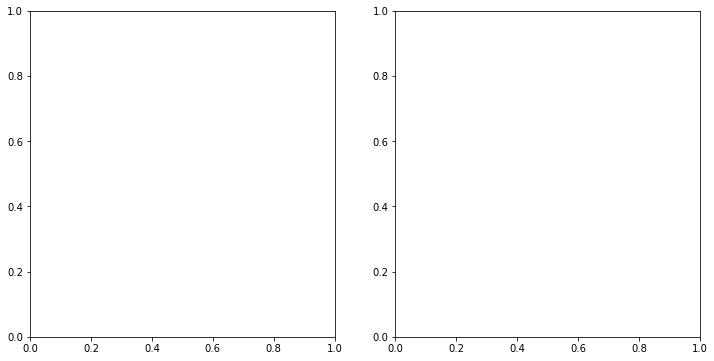

In [194]:
# blue.groupby('state').sum()
# data.groupby(['state','subject_race']).sum()
# blue.set_index(['state','subject_race']).loc['CT','white']
# blue
# full = pd.concat([blue,red])
# full_normalized = add_normalized_rates(full)
races = full.subject_race.unique()
states = full.state.unique()

temp =  get_weights(full.set_index(['state','subject_race']), states, races) 
data = add_normalized_rates(temp.reset_index())
data = add_normalized_rates(full)
methods = ["hit_rate_weighted_normalized", "threshold_weighted_normalized"]
ylim = [[0,1.25], [0,1.05]]
fig, axs = plt.subplots(1,2,figsize=(12,6))
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],data, params)
full.head()

In [ ]:
full = pd.concat([blue,red])
# full_normalized = add_normalized_rates(full)
races = full.subject_race.unique()
states = full.state.unique()

# temp =  get_weights(full.set_index(['state','subject_race']), states, races) 
# data = add_normalized_rates(temp.reset_index())
data = add_normalized_rates(full)
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]
fig, axs = plt.subplots(1,2,figsize=(12,6))
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],data, params)


In [213]:
tx_raw = df.loc[df["state"] == "TX"]
counties['party'] = np.where(counties["per_dem"] > counties["per_gop"], "blue", "red")
counties = counties.loc[counties["state_abbr"] == "TX"]
tx = tx_raw.drop(['state','party'],axis=1)
tx = pd.merge(left=tx, right=counties, left_on='subgeography', right_on='county_name')
tx = tx.drop(['votes_dem','votes_gop','state_abbr','county_name','combined_fips','Unnamed: 0'],axis=1)

In [201]:
tx.groupby('party').nb_search.sum()

party
blue     4153.925524
red     23681.255198
Name: nb_search, dtype: float64

<AxesSubplot:xlabel='nb_search', ylabel='Density'>

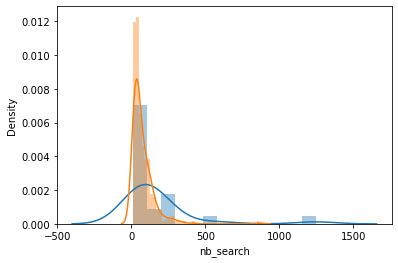

In [202]:
g = sns.distplot(tx[tx.party == 'blue'].nb_search, label = 'blue states')
sns.distplot(tx[tx.party == 'red'].nb_search, label = 'red states', ax = g)

We can see that there are more blue counties with high number of searches and that again most red counties have small number of searches.
However, given that there are a lot more red counties than blue counties there are more searches for red counties. We believe the this is still good enough to perform analysis on.

<AxesSubplot:xlabel='subject_race', ylabel='inferred_threshold'>

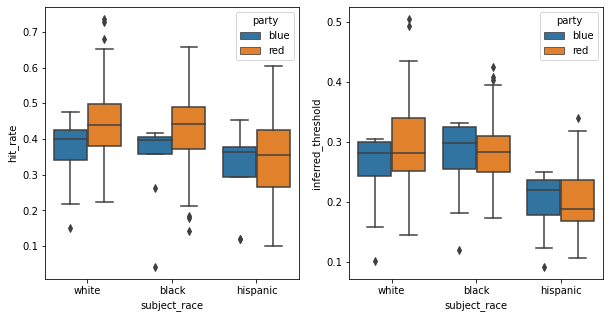

In [203]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data=tx, y="hit_rate", x="subject_race", hue = 'party', hue_order = ['blue', 'red'], ax = ax[0])
sns.boxplot(data=tx, y="inferred_threshold", x="subject_race", hue = 'party', hue_order = ['blue', 'red'], ax = ax[1])

Blue hit rates are again lower than red hit rates. However this does not give us any indication on the bias.

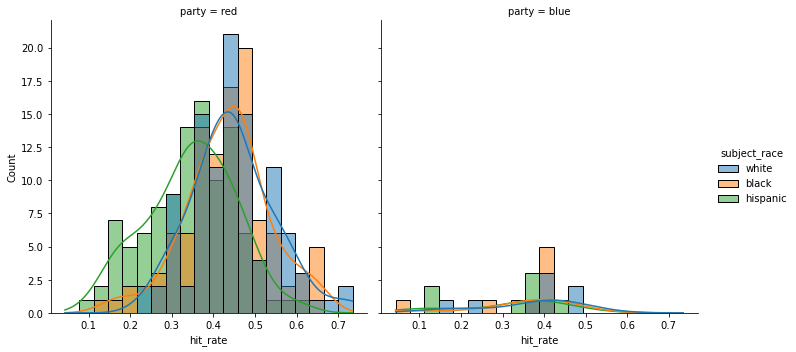

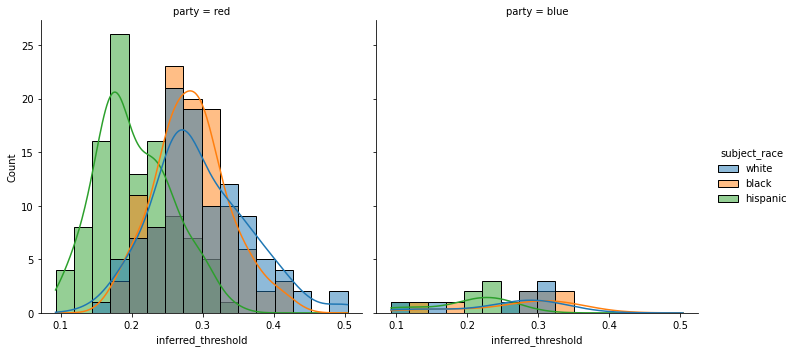

In [204]:
sns.displot(data=tx, x="hit_rate", hue="subject_race", col="party", kde = True)
sns.displot(data=tx, x="inferred_threshold", hue="subject_race", col="party", kde=True)

In [205]:
print(diagnostic.kstest_normal(tx.hit_rate, dist = 'norm'))
print(diagnostic.kstest_normal(tx.inferred_threshold, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['blue'].hit_rate.white, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['blue'].inferred_threshold.hispanic, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['red'].hit_rate.white, dist = 'norm'))
print(diagnostic.kstest_normal(full_pivot.loc['red'].inferred_threshold.hispanic, dist = 'norm'))

(0.064750568368659, 0.002880813936626427)
(0.03765083287789758, 0.3584664413132878)
(0.1007900857526729, 0.5778193798896908)
(0.13244668732730136, 0.1885279279732509)
(0.065747278715727, 0.17403441585970786)
(0.07866208425108001, 0.0414062467744477)


In [206]:
print(stats.spearmanr(tx['nb_search'],tx['hit_rate']))
print(stats.spearmanr(tx['nb_search'],tx['inferred_threshold']))

SpearmanrResult(correlation=-0.012236141875115514, pvalue=0.8223935251011338)
SpearmanrResult(correlation=-0.13054714476249735, pvalue=0.016170215970718948)


In [207]:
print(stats.spearmanr(tx[tx.subject_race == 'hispanic']['nb_search'],tx[tx.subject_race == 'hispanic']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'hispanic']['nb_search'],tx[tx.subject_race == 'hispanic']['inferred_threshold']))
print(stats.spearmanr(tx[tx.subject_race == 'white']['nb_search'],tx[tx.subject_race == 'white']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'white']['nb_search'],tx[tx.subject_race == 'white']['inferred_threshold']))
print(stats.spearmanr(tx[tx.subject_race == 'black']['nb_search'],tx[tx.subject_race == 'black']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'black']['nb_search'],tx[tx.subject_race == 'black']['inferred_threshold']))

SpearmanrResult(correlation=0.045208524370740265, pvalue=0.634449800186034)
SpearmanrResult(correlation=-0.18638132942976915, pvalue=0.04808827366712917)
SpearmanrResult(correlation=-0.07690964136003728, pvalue=0.4181294387137159)
SpearmanrResult(correlation=-0.20668374476013046, pvalue=0.028061653207698344)
SpearmanrResult(correlation=-0.07280938687176161, pvalue=0.44344618296034977)
SpearmanrResult(correlation=-0.25533135937188106, pvalue=0.0063444404542834)


In [208]:
pivot_tx = tx.pivot(index = ['party', 'subgeography'] , columns = 'subject_race')
pivot_tx

search_rate                     stop_rate            \
subject_race                  black  hispanic     white     black  hispanic   
party subgeography                                                            
blue  Bexar County         0.021990  0.024835  0.013096   0.06723  0.069734   
      Culberson County     0.017133  0.015029  0.008045   0.06723  0.069734   
      Dallas County        0.021643  0.017937  0.012143   0.06723  0.069734   
      El Paso County       0.030395  0.018578  0.015450   0.06723  0.069734   
      Fort Bend County     0.011105  0.011390  0.006566   0.06723  0.069734   
...                             ...       ...       ...       ...       ...   
red   Wharton County       0.027572  0.042115  0.010523   0.06723  0.069734   
      Wichita County       0.057150  0.043787  0.021745   0.06723  0.069734   
      Wilbarger County     0.023802  0.014195  0.006876   0.06723  0.069734   
      Williamson County    0.025413  0.024083  0.013453   0.06723  0.069734   
      Wise County          0.043500  0.026597  0.015098   0.06723  0.069734   

                                   hit_rate                      \
subject_race                white     black  hispanic     white   
party subgeography                                                
blue  Bexar County       0.091078  0.402878  0.370023  0.410367   
      Culberson County   0.091078  0.263158  0.119910  0.217054   
      Dallas County      0.091078  0.392606  0.452096  0.474110   
      El Paso County     0.091078  0.406897  0.364799  0.476895   
      Fort Bend County   0.091078  0.407249  0.352365  0.382831   
...                           ...       ...       ...       ...   
red   Wharton County     0.091078  0.548780  0.266531  0.537143   
      Wichita County     0.091078  0.606695  0.439252  0.563006   
      Wilbarger County   0.091078  0.533333  0.327273  0.551546   
      Williamson County  0.091078  0.494577  0.322340  0.396644   
      Wise County        0.091078  0.489914  0.412892  0.451655   

                        inferred_threshold  ...   per_dem   per_gop            \
subject_race                         black  ...     white     black  hispanic   
party subgeography                          ...                                 
blue  Bexar County                0.331674  ...  0.544659  0.409804  0.409804   
      Culberson County            0.182624  ...  0.595801  0.367454  0.367454   
      Dallas County               0.323425  ...  0.611264  0.348851  0.348851   
      El Paso County              0.278581  ...  0.691392  0.259277  0.259277   
      Fort Bend County            0.327966  ...  0.516483  0.450180  0.450180   
...                                    ...  ...       ...       ...       ...   
red   Wharton County              0.320722  ...  0.288162  0.690080  0.690080   
      Wichita County              0.310999  ...  0.230844  0.728220  0.728220   
      Wilbarger County            0.323033  ...  0.196781  0.772007  0.772007   
      Williamson County           0.305252  ...  0.420159  0.518786  0.518786   
      Wise County                 0.277676  ...  0.138356  0.837557  0.837557   

                                      diff                   per_point_diff  \
subject_race                white    black hispanic    white          black   
party subgeography                                                            
blue  Bexar County       0.409804   79,030   79,030   79,030         13.49%   
      Culberson County   0.367454      174      174      174         22.83%   
      Dallas County      0.348851  196,980  196,980  196,980         26.24%   
      El Paso County     0.259277   90,942   90,942   90,942         43.21%   
      Fort Bend County   0.450180   17,263   17,263   17,263          6.63%   
...                           ...      ...      ...      ...            ...   
red   Wharton County     0.690080    5,911    5,911    5,911         40.19%   
      Wichita County     0.728220   18,857   18,857  

In [209]:
import warnings
warnings.filterwarnings('ignore')

weights = pivot_tx.loc['blue'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
tx_blue = tx[tx.party == 'blue'].merge(weights, on = ['subgeography','subject_race'])

weights = pivot_tx.loc['red'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
tx_red = tx[tx.party == 'red'].merge(weights, on = ['subgeography','subject_race'])

#create dataframes with normalized values, using the pivoted dataframe so we can apply get normalize to each row containing race specific
hit_rate_normalized = pivot_tx.hit_rate.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'hit_rate_normalized'})
threshold_normalized = pivot_tx.inferred_threshold.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'threshold_normalized'})
hit_rate_normalized
threshold_normalized
tx_blue = tx_blue.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography', 'subject_race','party'])
tx_red = tx_red.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography', 'subject_race','party'])

tx_blue['hit_rate_weighted'] = tx_blue.hit_rate*tx_blue.weight
tx_blue['threshold_weighted'] = tx_blue.inferred_threshold*tx_blue.weight
tx_red['hit_rate_weighted'] = tx_red.hit_rate*tx_red.weight
tx_red['threshold_weighted'] = tx_red.inferred_threshold*tx_red.weight
tx_blue['hit_rate_weighted_normalized'] = tx_blue.hit_rate_normalized*tx_blue.weight
tx_blue['threshold_weighted_normalized'] = tx_blue.threshold_normalized*tx_blue.weight
tx_red['hit_rate_weighted_normalized'] = tx_red.hit_rate_normalized*tx_red.weight
tx_red['threshold_weighted_normalized'] = tx_red.threshold_normalized*tx_red.weight

In [210]:
tx_blue.head()

,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_search,total_votes,...,diff,per_point_diff,party,weight,hit_rate_normalized,threshold_normalized,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
0,Bexar County,white,0.013096,0.091078,0.410367,0.298590,5605.714286,1.070666e+06,73.413071,586038.0,...,"79,030",13.49%,blue,0.093915,1.000000,1.000000,0.038540,0.028042,0.093915,0.093915
1,Bexar County,black,0.021990,0.067230,0.402878,0.331674,1268.857143,2.150716e+05,27.902411,586038.0,...,"79,030",13.49%,blue,0.044283,0.981749,1.110800,0.017841,0.014687,0.043475,0.049189
2,Bexar County,hispanic,0.024835,0.069734,0.370023,0.209974,9190.571429,7.443300e+05,228.245323,586038.0,...,"79,030",13.49%,blue,0.083236,0.901689,0.703219,0.030799,0.017478,0.075053,0.058533
3,Culberson County,white,0.008045,0.091078,0.217054,0.159095,2927.428571,1.070666e+06,23.550875,762.0,...,174,22.83%,blue,0.030128,1.000000,1.000000,0.006539,0.004793,0.030128,0.030128
4,Culberson County,black,0.017133,0.067230,0.263158,0.182624,642.285714,2.150716e+05,11.003993,762.0,...,174,22.83%,blue,0.017464,1.212406,1.147890,0.004596,0.003189,0.021173,0.020047


In [211]:
results_blue = pd.concat([tx_blue.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          tx_blue.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T
results_red = pd.concat([tx_red.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          tx_red.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T

In [212]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(results_blue,results_red)

subject_race,black,hispanic,white
hit_rate,0.340110,0.317911,0.363883
inferred_threshold,0.270343,0.197877,0.250464
hit_rate_normalized,0.904808,0.850641,1.000000
threshold_normalized,1.092983,0.801940,1.000000
hit_rate_weighted,0.388619,0.251140,0.395255
threshold_weighted,0.303134,0.163061,0.273854
hit_rate_weighted_normalized,0.953272,0.828129,1.000000
threshold_weighted_normalized,1.082935,0.852314,1.000000
subject_race,black,hispanic,white
hit_rate,0.434453,0.345940,0.445877
